# The Game Shop

The dataset is open-source info about sales and reviews about videogames from 1985 to 2016.

The data contains:
* The name of the game
* Platform
* Release year
* Genre
* Sales by regions
* User ratings
* ESRB rating

The goal is to identify the parameters and patterns that determine whether a particular game will be successful.

## Intro

### Importing modules and the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st

In [2]:
df = pd.read_csv('games.csv')
initial_length = len(df) #saving the initial volume of data to compare later

### Meeting the data

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


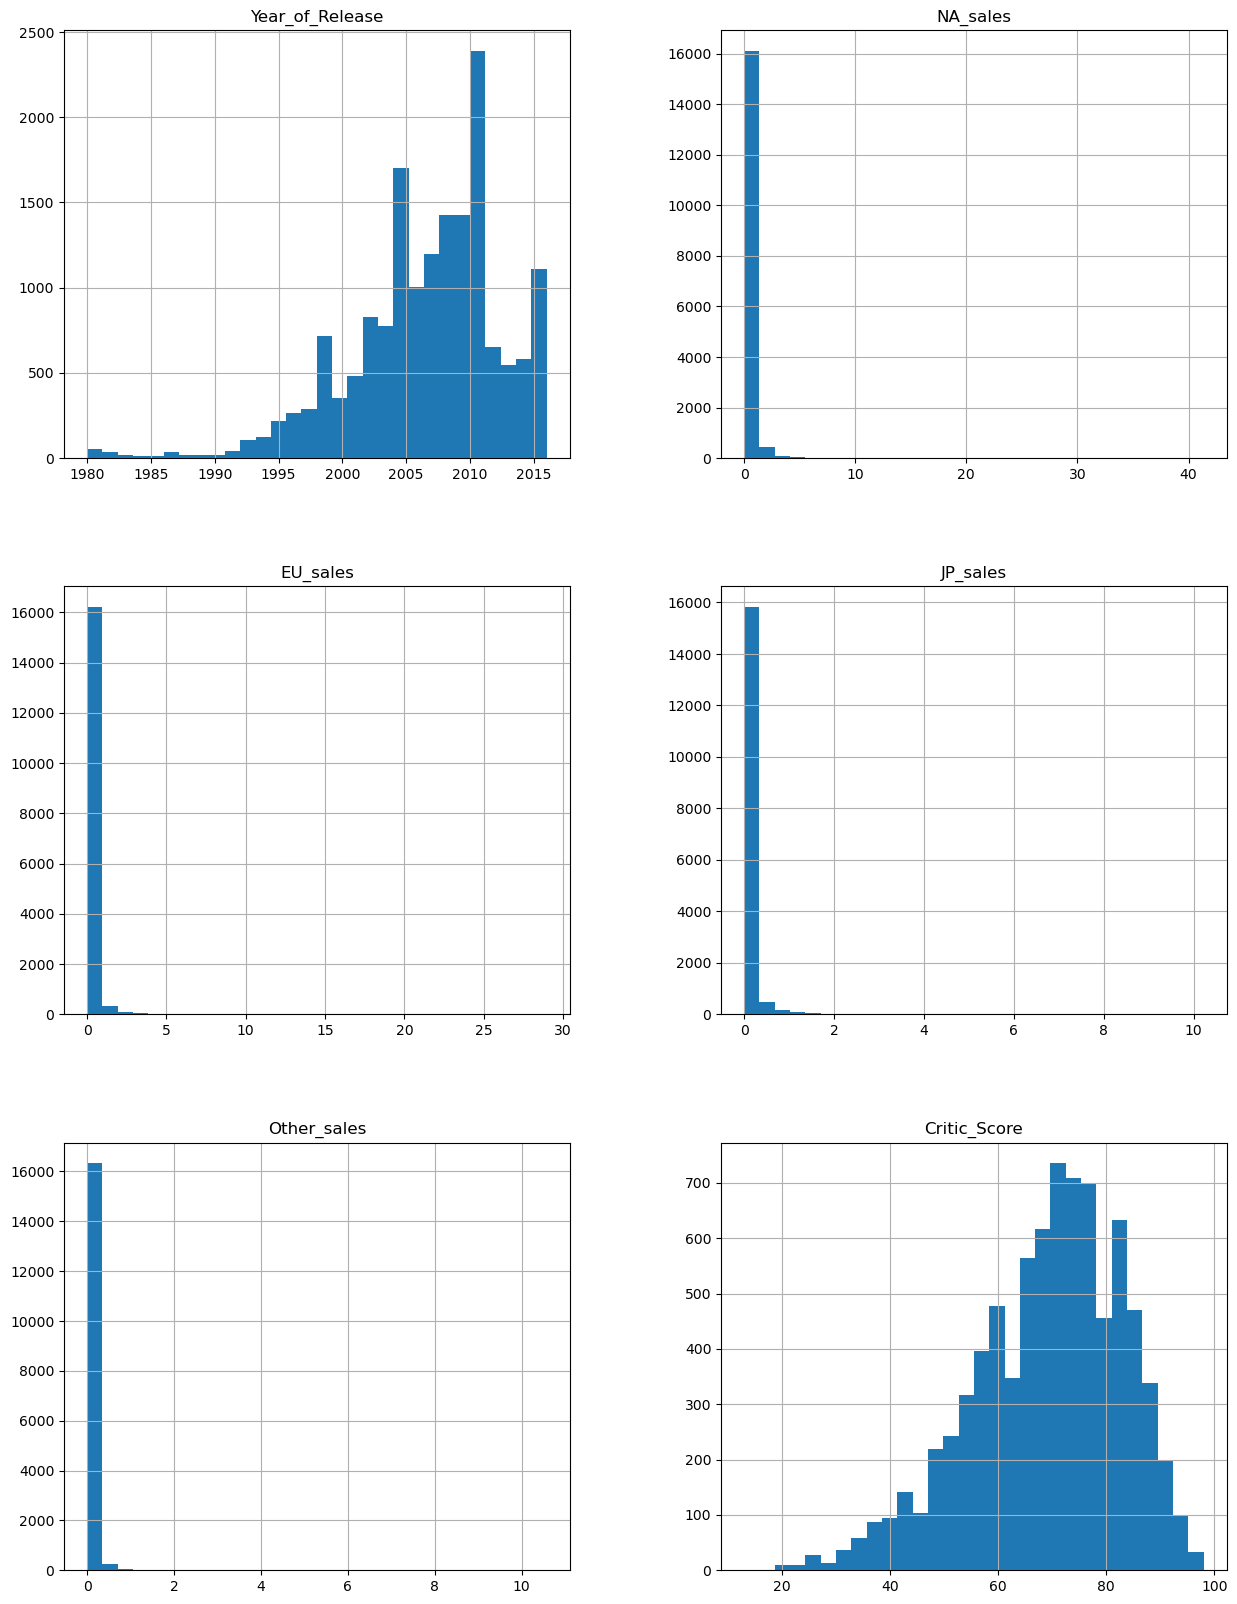

In [5]:
df.hist(bins=30, figsize = (15, 20))
plt.show()

## Preparing data

### Column names

In [6]:
df.columns = df.columns.str.lower()
df = df.rename(columns = {'year_of_release':'release_year',
                         'rating':'esrb_rating'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   release_year  16446 non-null  float64
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    10014 non-null  object 
 10  esrb_rating   9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Checking for duplicates

In [7]:
df.duplicated().sum()

0

There are no obvious duplicates. However, need to check for implicit duplicates - the same game will not be released twice on the same platform:

In [8]:
df[df.duplicated(subset=['name', 'platform'])]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


5 lines are duplicated. Deleting duplicates:

In [9]:
df = df.drop_duplicates(subset=['name', 'platform'])

### Gaps

* The gaps in the critic_score, user_score and esrb_rating columns should be left: we cannot replace them with the median value, as this may distort the overall picture.
* Gaps in the release_year column will be removed - they are less than 1% of the total data.
* Gaps in the name and genre columns:

In [10]:
df[df['genre'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


This line has no useful info, we can delete it

In [11]:
df = df.dropna(subset = ['release_year','name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16441 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16441 non-null  object 
 1   platform      16441 non-null  object 
 2   release_year  16441 non-null  float64
 3   genre         16441 non-null  object 
 4   na_sales      16441 non-null  float64
 5   eu_sales      16441 non-null  float64
 6   jp_sales      16441 non-null  float64
 7   other_sales   16441 non-null  float64
 8   critic_score  7980 non-null   float64
 9   user_score    9836 non-null   object 
 10  esrb_rating   9765 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


### Variables types

release_year is in float64, but we need info on yearly basis, so we put it into int64

In [12]:
df = df.astype({'release_year':'int'})

user_score is an object type, but we need it as a number to compare against each other. New type is float64.
The reason why it is object is because there is a "tbd" value. We will change it for NaN. NaN is a float type, so it would be convenient to use with numbers.

In [13]:
df['user_score'] = pd.to_numeric(df['user_score'], errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16441 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16441 non-null  object 
 1   platform      16441 non-null  object 
 2   release_year  16441 non-null  int32  
 3   genre         16441 non-null  object 
 4   na_sales      16441 non-null  float64
 5   eu_sales      16441 non-null  float64
 6   jp_sales      16441 non-null  float64
 7   other_sales   16441 non-null  float64
 8   critic_score  7980 non-null   float64
 9   user_score    7460 non-null   float64
 10  esrb_rating   9765 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


### Adding calculations

We also need total sales for all regions

In [14]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Introduction TLDR

The largest amount of missing data is in the rating columns. This is unfortunate, but ratings are provided by users and critics on specialized portals/magazines/other media. Often, the game may not be represented on the platform at all - such as Super Mario Bros for the NES platform is not available on Steam. However, it is still important for a publisher/retailer to consider such games - they won't be able to get their hands on them specifically, but they provide important indicators for the platform and development studios.

In [15]:
len(df) / initial_length

0.9836075381393957

98,38% of the starting data is still there, we haven't lost much.

## Analysis

### How many games were released each year?

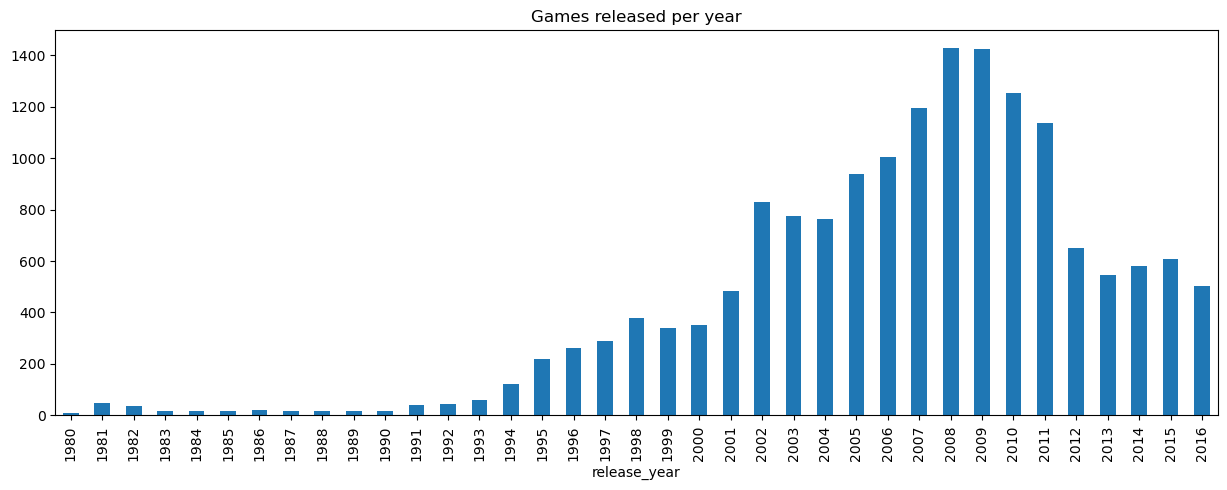

In [16]:
df.groupby('release_year')['release_year'].count().plot(kind='bar', title = 'Games released per year', figsize = (15,5))
plt.show()

2008 and 2009 were the most productive years for video games. The growth on the left side of the graph is clear - personal computers and consoles became more accessible, video games moved from geek culture into the mainstream, making video games and making money from selling them became increasingly easier. I will assume that the drop on the right side of the graph is associated with the global economic crisis - in the mid-2000s, video game production was already a serious big business and could not help but be affected by the problems of the global economy. The decline does not happen immediately - the development cycle of an AAA game takes several years, and games whose development began before the crisis continue to be released for some time.

Is data for all periods important? No, I guess you can set the cutoff at 1991 - the release of several important games, each of which gained enormous worldwide popularity (The Legend of Zelda: A Link to the Past, Sonic the Hedgehog, SimCity), marked the transition of video games from a local, highly specialized industry to big business. We see that from this moment a steady growth begins on the chart.

### How many games were released on each platform?

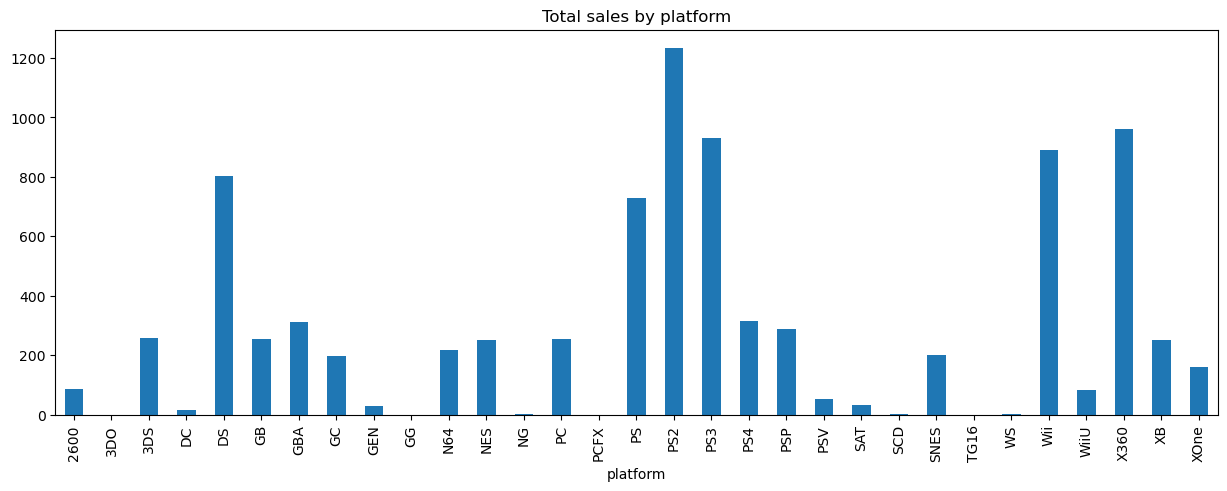

In [17]:
df.groupby('platform')['total_sales'].sum().plot(kind='bar', title = 'Total sales by platform', figsize = (15,5))
plt.show()

Let's consider the life cycle of the platform. I think it's best to look at a series of gaming platforms - they are created, live and die according to the plans of large corporations. I will consider platforms Nintendo, SONY Playstation, Xbox and PC

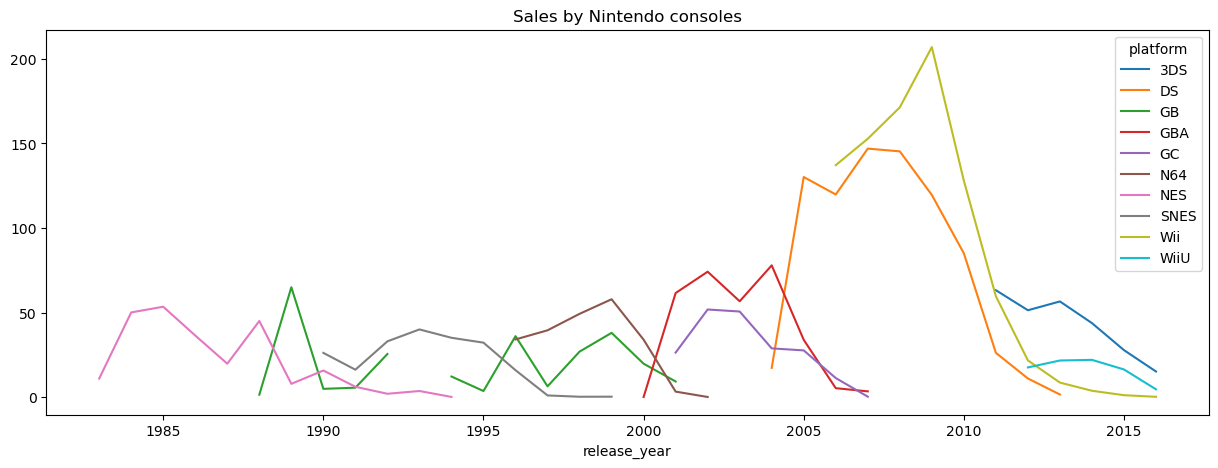

In [18]:
df.query('platform in ["DS", "GC", "NES", "SNES", "GB", "GBA", "N64", "Wii", "WiiU", "3DS"]').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Sales by Nintendo consoles', figsize = (15,5))
plt.show()

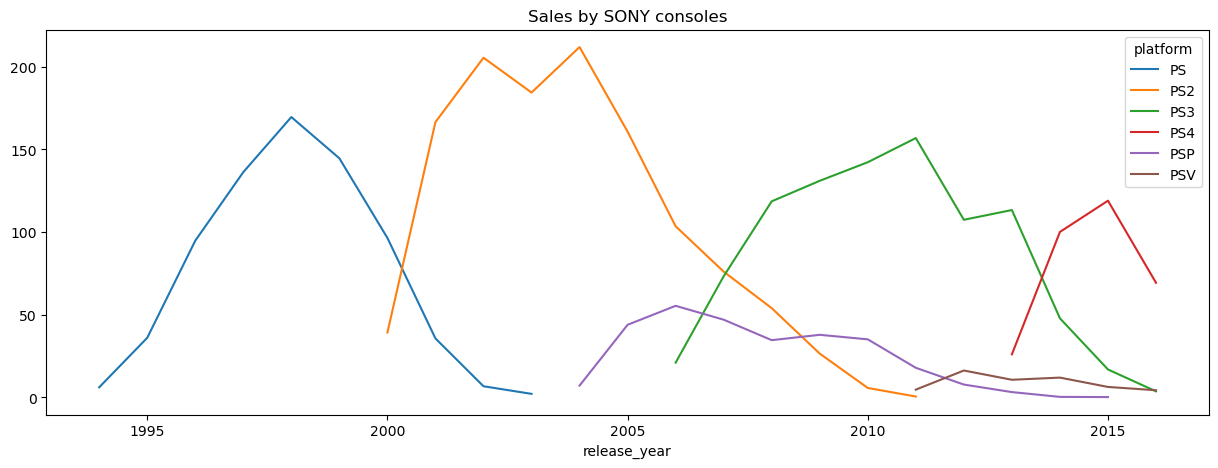

In [19]:
df.query('platform in ["PS", "PS2", "PS3", "PS4", "PS5", "PSP", "PSV"]').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Sales by SONY consoles', figsize = (15,5))
plt.show()

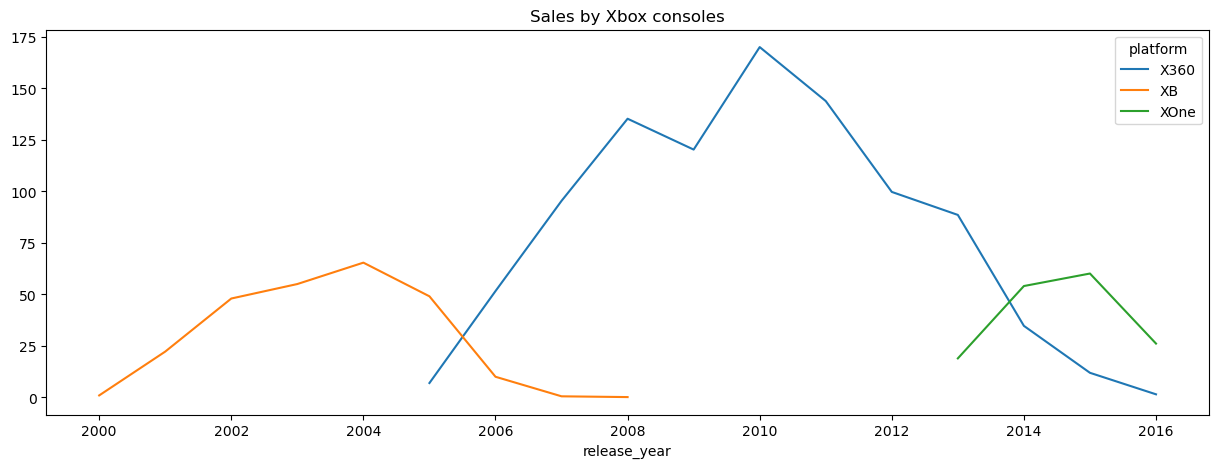

In [20]:
df.query('platform in ["XB", "XOne", "X360"]').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Sales by Xbox consoles', figsize = (15,5))
plt.show()

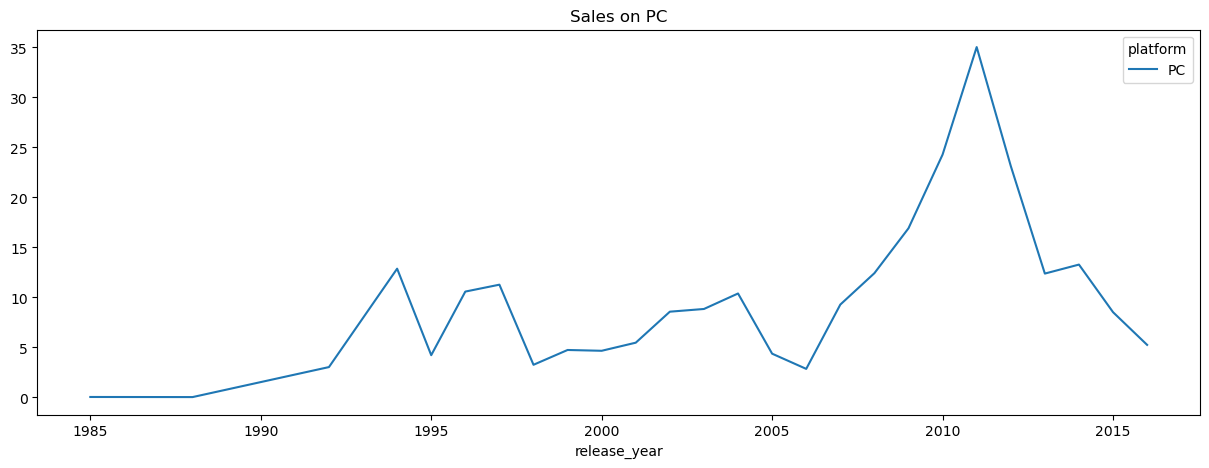

In [21]:
df.query('platform == "PC"').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Sales on PC', figsize = (15,5))
plt.show()

Let's calculate how long a gaming platform gets sales on average

In [22]:
def lifecycle(platform): #функция составляет сводную таблицу по конкретной платформе, где в каждой строке - продажи за год и суммирует количество строк.
    data = df[df['platform'] == platform].pivot_table(index = 'release_year', values = 'total_sales', aggfunc = 'sum')
    return len(data)


df.groupby('platform')['platform'].first().apply(lifecycle).median()

7.0

Median life cycle of the platform is 7 years

### What period shall we consider when talking about "current data"?

In the last paragraph, we found out that as soon as a platform’s sales begin to fall, this means that a couple of years before that, developers and publishers stopped introducing new games for this platform, and now only the laggards are releasing the leftovers. Thus, if we use data for the last two years, a trend of both growth and decline will already be visible.

Let's create a separate dataframe for current data.

In [23]:
latest_data = df[df['release_year'] >= 2015]
latest_data.head()

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39


### Which platforms are leading the market?

The most successful platforms of all time are Playstation 2, Xbox360, Nintendo Wii, Playstation 3, Nintendo DS. Let's consider their dynamics.

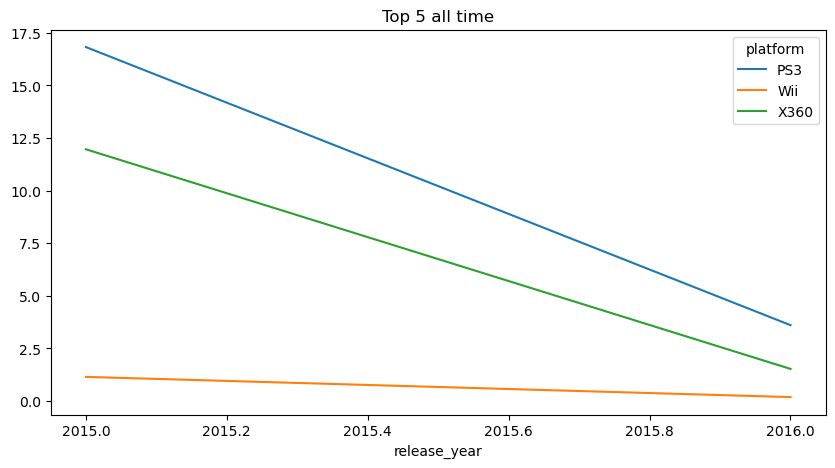

In [24]:
latest_data.query('platform in ["PS2", "X360", "Wii", "PS3", "DS"]').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Top 5 all time', figsize = (10,5))
plt.show()

Not really useful. It is obvious now that we need to consider the best platforms for the last 2 years. Let's find out which ones.

In [25]:
latest_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head()

,total_sales
platform,
PS4,188.15
XOne,86.29
3DS,42.92
WiiU,20.95
PS3,20.42


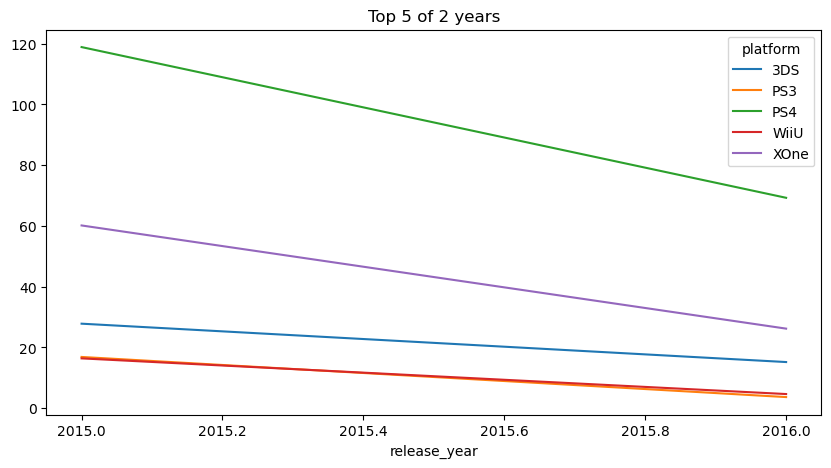

In [26]:
top_five = latest_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head().index
latest_data.query('platform in @top_five').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Top 5 of 2 years', figsize = (10,5))
plt.show()

Sadly, all these platforms are falling too. Maybe there are upcoming platforms that are yet to be successful?

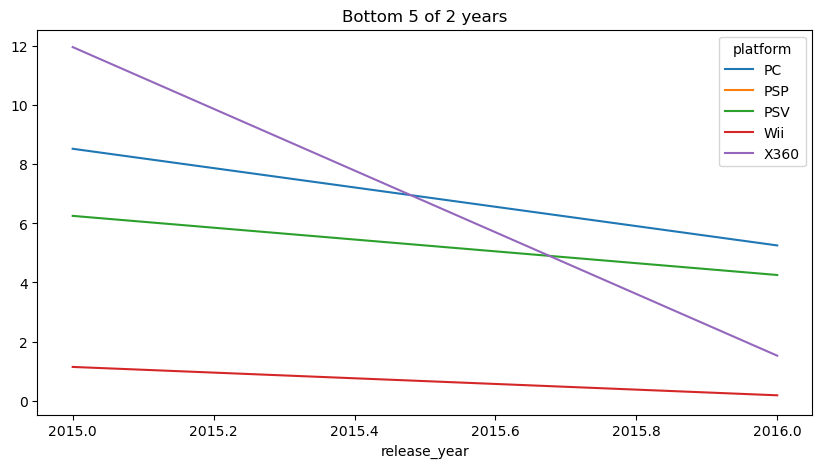

In [27]:
latest_data.query('platform not in @top_five').pivot_table(index='release_year', columns='platform', values='total_sales', aggfunc='sum').plot(title='Bottom 5 of 2 years', figsize = (10,5))
plt.show()

No, not relly. The best course of action now is try to get on PS4, XBoxOne and 3DS bandwagon - their sales are still high, and they are going to stay relevant for some time.

### Box and whisker for global sales

We'll make a box and whisker plot for top-3 platforms of the last two years

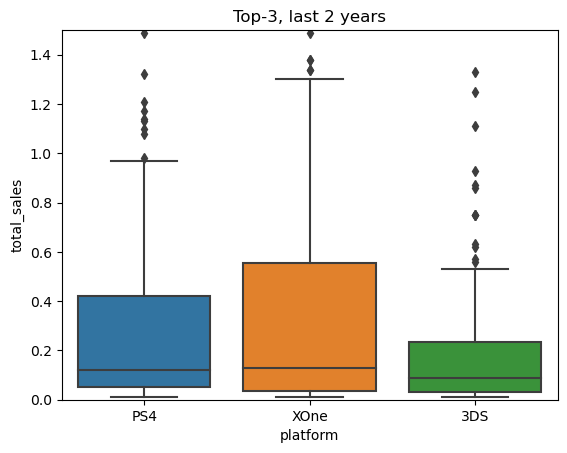

In [28]:
top_three = latest_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(3).index
plt.ylim(0,1.5)
sb.boxplot(data=latest_data.query('platform in @top_three'), x='platform', y='total_sales').set(title='Top-3, last 2 years')
plt.show()

It is noticeable that the scatter is very different. This is probably due to the total number of sales - for example, a great many games from a variety of studios were released on the Xbox One - and the spread of sales is large, but on the Nintendo 3DS - only those that were specially developed for this console and passed a rather strict selection in the internal Nintendo store - and there is less variation here.

### Do reviews correlate with sales?

Let's consider total sales and critic scores for top-3 consoles:

0.3928485555130601

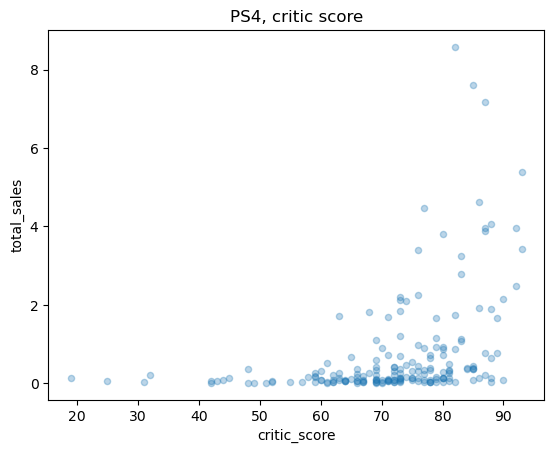

In [29]:
latest_data[latest_data['platform'] == 'PS4'].plot(kind='scatter', x='critic_score', y='total_sales', title='PS4, critic score', alpha=0.3)
latest_data[latest_data['platform'] == 'PS4']['total_sales'].corr(latest_data[latest_data['platform'] == 'PS4']['critic_score'])

0.39 is a weak correlation. But there's an interesting part: it looks like most ratings are from 60 to 80. Let's invoke another box and whisker:

count    185.000000
mean      71.891892
std       12.595254
min       19.000000
25%       66.000000
50%       73.000000
75%       80.000000
max       93.000000
Name: critic_score, dtype: float64

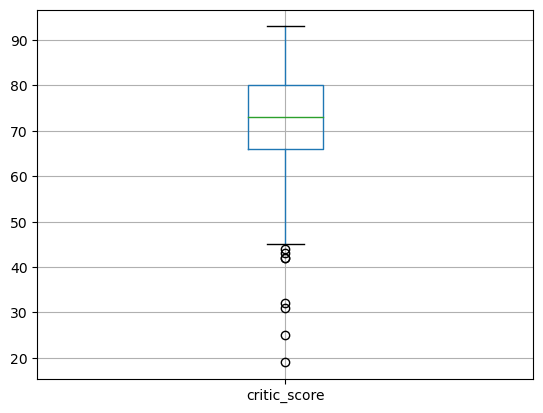

In [30]:
latest_data[latest_data['platform']=='PS4'].boxplot(column='critic_score')
latest_data[latest_data['platform']=='PS4']['critic_score'].describe()

There it is - median rating is 73%. This is a good illustration for [the four-point scale](https://tvtropes.org/pmwiki/pmwiki.php/Main/FourPointScale).
But back to ratings. Let's look into user scores for PS4:

In [31]:
latest_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1108 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1108 non-null   object 
 1   platform      1108 non-null   object 
 2   release_year  1108 non-null   int32  
 3   genre         1108 non-null   object 
 4   na_sales      1108 non-null   float64
 5   eu_sales      1108 non-null   float64
 6   jp_sales      1108 non-null   float64
 7   other_sales   1108 non-null   float64
 8   critic_score  457 non-null    float64
 9   user_score    559 non-null    float64
 10  esrb_rating   595 non-null    object 
 11  total_sales   1108 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 108.2+ KB


-0.05973845712638215

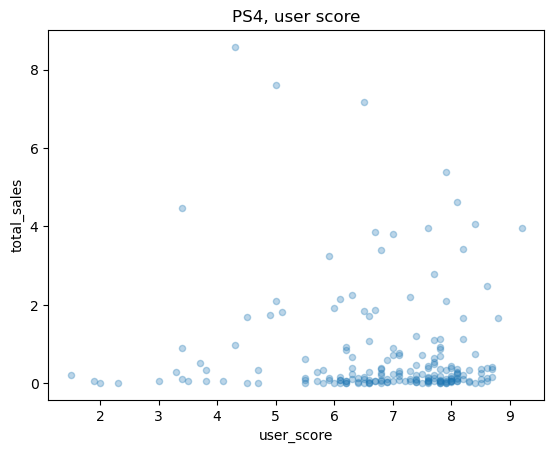

In [32]:
latest_data[latest_data['platform'] == 'PS4'].plot(kind='scatter', x='user_score', y='total_sales', title='PS4, user score', alpha=0.3)
latest_data[latest_data['platform'] == 'PS4']['total_sales'].corr(latest_data[latest_data['platform'] == 'PS4']['user_score'])

As we can see, user are expressing their mind freely and without any correlation with the sales.

Now critic rates for XOne:

0.430888745821368

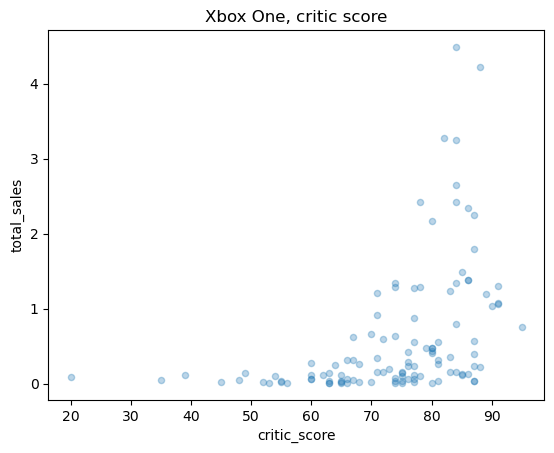

In [33]:
latest_data[latest_data['platform'] == 'XOne'].plot(kind='scatter', x='critic_score', y='total_sales', title='Xbox One, critic score', alpha=0.3)
latest_data[latest_data['platform'] == 'XOne']['total_sales'].corr(latest_data[latest_data['platform'] == 'XOne']['critic_score'])

The correlation is still weak, but a bit stronger than PS4 has

-0.04146733387366271

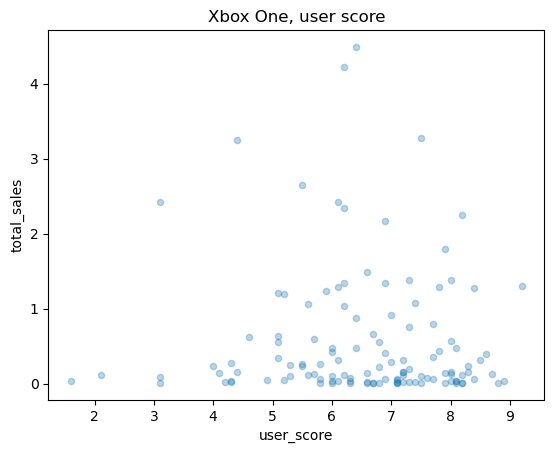

In [34]:
latest_data[latest_data['platform'] == 'XOne'].plot(kind='scatter', x='user_score', y='total_sales', title='Xbox One, user score', alpha=0.3)
latest_data[latest_data['platform'] == 'XOne']['total_sales'].corr(latest_data[latest_data['platform'] == 'XOne']['user_score'])

Just like PS4, the correlation coefficient is negative. From a strictly mathematical point of view, we should interpret it as a very weak feedback, but since we understand that users want to give a good rating to a good game, and a bad rating to a bad one (well, they usually try) - this means that there is no correlation at all.

0.17757455046092874

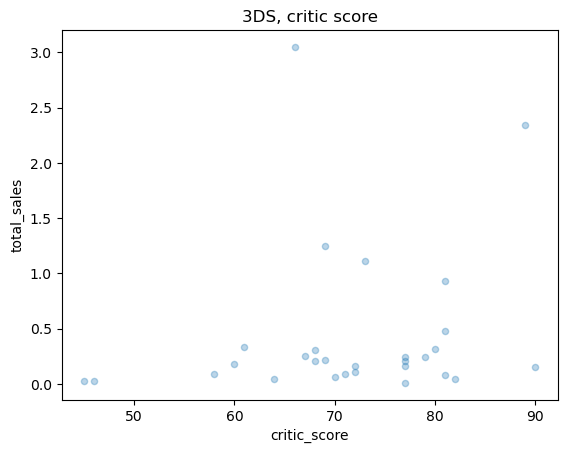

In [35]:
latest_data[latest_data['platform'] == '3DS'].plot(kind='scatter', x='critic_score', y='total_sales', title='3DS, critic score', alpha=0.3)
latest_data[latest_data['platform'] == '3DS']['total_sales'].corr(latest_data[latest_data['platform'] == '3DS']['critic_score'])

That's a relly weak correlation - weaker than PS4 or Xbox

0.19879627008102985

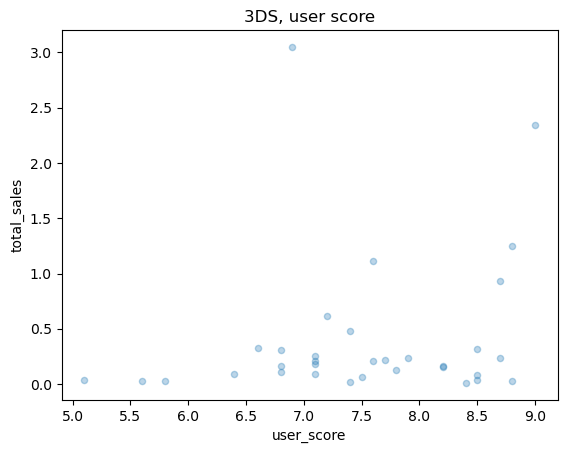

In [36]:
latest_data[latest_data['platform'] == '3DS'].plot(kind='scatter', x='user_score', y='total_sales', title='3DS, user score', alpha=0.3)
latest_data[latest_data['platform'] == '3DS']['total_sales'].corr(latest_data[latest_data['platform'] == '3DS']['user_score'])

The situation is radically different from desktop consoles - there is definitely a correlation, and even higher than that of critics' reviews! This is likely due to Nintendo's tighter community, fewer games overall, and the fact that the main publisher of 3DS games is Nintendo themselves.

### Games by genre

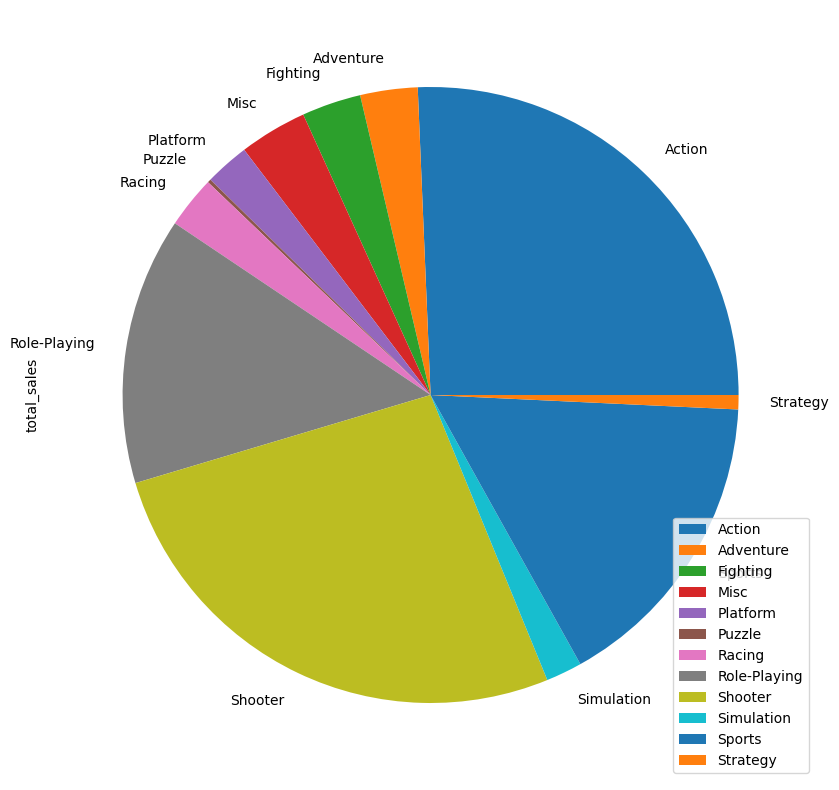

In [37]:
latest_data.pivot_table(index='genre', values='total_sales', aggfunc='sum').plot(kind='pie', y='total_sales', figsize=(15,10))
plt.show()

We see a clear dominance of the action genre on the market, which, in general, is quite logical: This is an extremely vague concept, which can include shooters, fighting games, and platformers. In general, everything that distinguishes video games from other media, such as: visual stimuli, feelings of triumph and satisfaction, the effect of immersion in a rapidly changing environment - all this, by definition, is the Action genre. Puzzles and strategies are also good and enjoyable, but give the player a rich, non-committal action movie - and he will be happy all evening (this works with cinema too!)

Also, in general, the division into genres is very arbitrary and is only needed essentially as a coded intro. The words like “Roguelike space simulator” will give the potential buyer a lot of information about what to expect from the video game.

However, we only looked at the amount of sales, identifying the genre in which the most successful games are produced. The genre in which the game has the greatest average chance of being successful is determined by the median sales value within the genre:

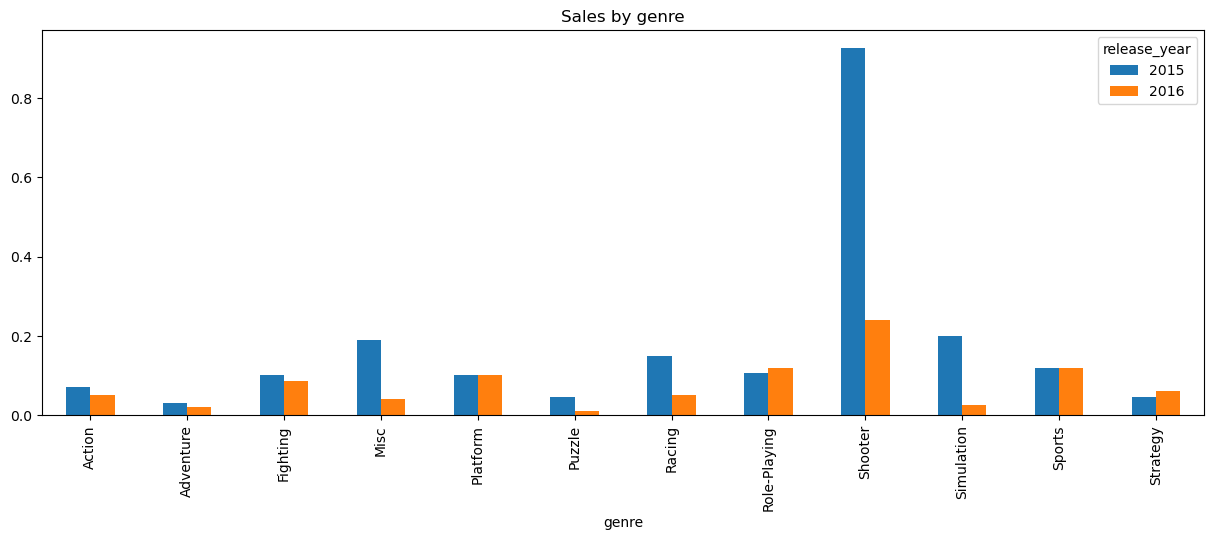

In [38]:
latest_data.pivot_table(index='genre', columns='release_year', values='total_sales', aggfunc='median').plot(kind='bar', title='Sales by genre', figsize=(15,5))
plt.show()

2015 is plentiful for shooters. 2016 is much lower, but still - median sales are still higher than any other genre

## Users from different regions

### Populer platforms

Considering popularity of top-3 active platform in the regions:

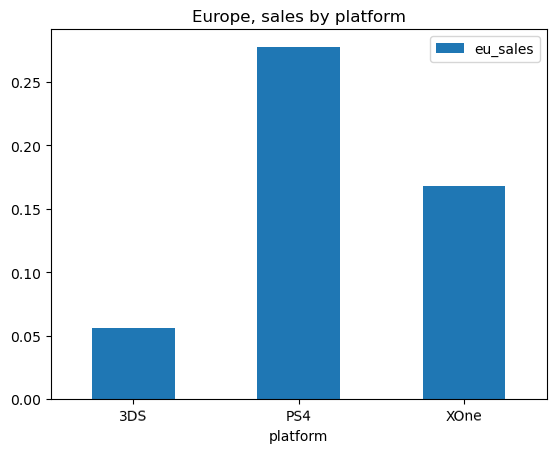

In [39]:
latest_data.query('platform in @top_three').pivot_table(index='platform', values='eu_sales').plot(kind='bar', rot=1, title='Europe, sales by platform')
plt.show()

Europe is dominated by PS4

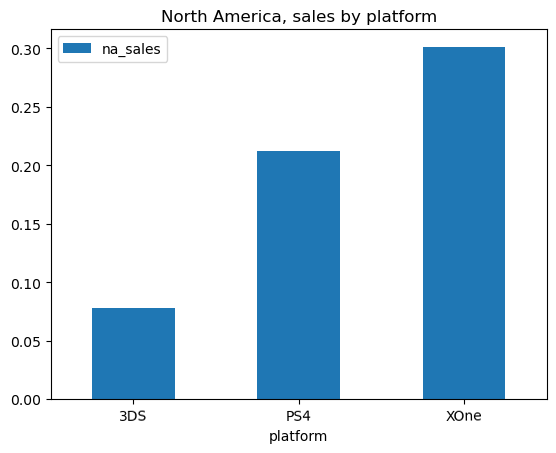

In [40]:
latest_data.query('platform in @top_three').pivot_table(index='platform', values='na_sales').plot(kind='bar', rot=1, title='North America, sales by platform')
plt.show()

In NA there's a significant surge of XOne. Numbers for 3DS and PS4 are about the same, but XBox gained more than twice the sales!

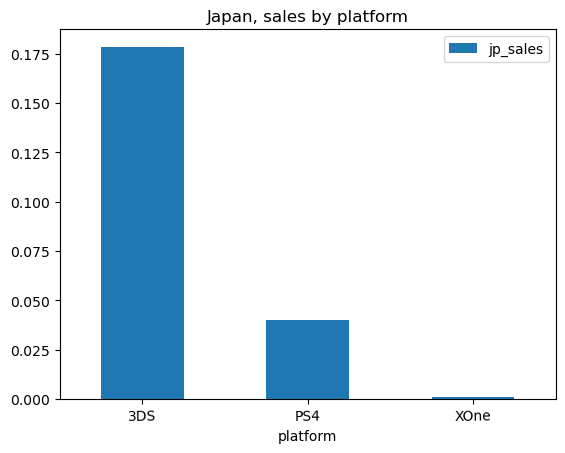

In [41]:
latest_data.query('platform in @top_three').pivot_table(index='platform', values='jp_sales').plot(kind='bar', rot=1, title='Japan, sales by platform')
plt.show()

An interesting distribution - Japanese users prefer portable consoles. This is probably due to the traditional financial problems of the modern Japanese young man - he is always on the road and always “on the run” to earn money, and in a rented [three tatami roon](https://www.world-today-news.com/in-the-three-tatami-rooms-9-square-meters-to-accommodate-the-young-people-of-tokyo/) every bit of free space counts. Gamers in both EU and NA prefer more powerful stationary consoles that connect to the TV.

### Popular genre

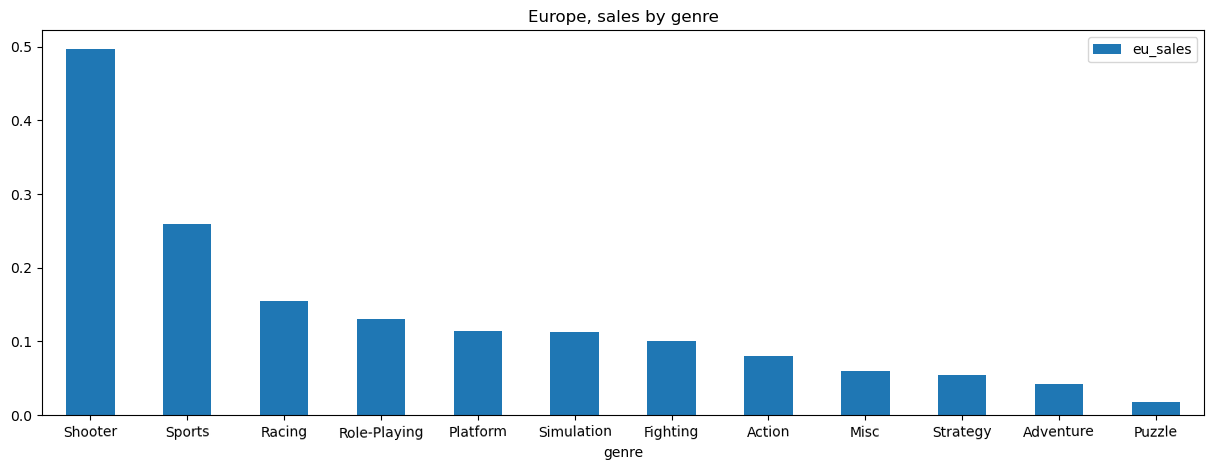

In [42]:
latest_data.pivot_table(index='genre', values='eu_sales').sort_values(by='eu_sales', ascending=False).plot(kind='bar', rot=1, title='Europe, sales by genre', figsize=(15,5))
plt.show()

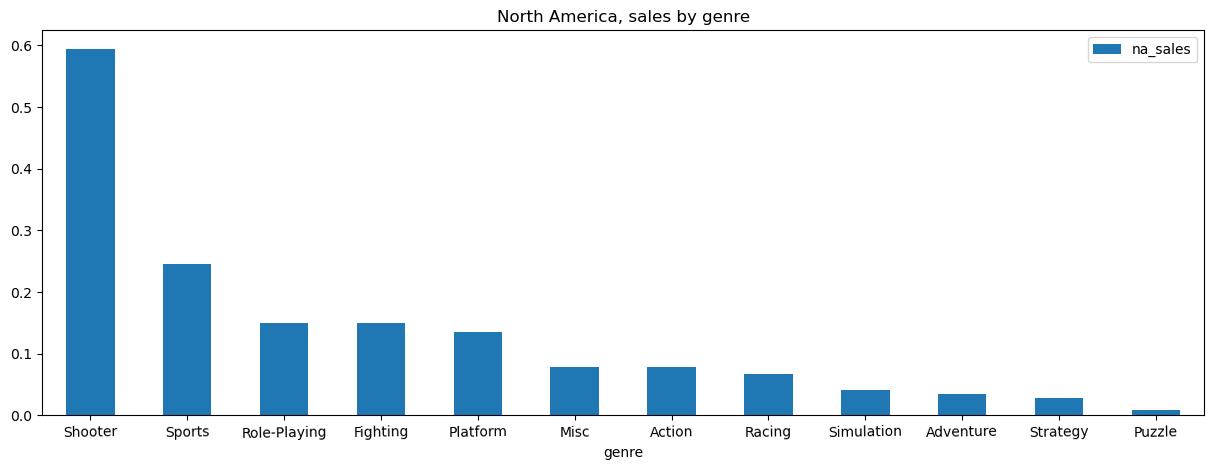

In [43]:
latest_data.pivot_table(index='genre', values='na_sales').sort_values(by='na_sales', ascending=False).plot(kind='bar', rot=1, title='North America, sales by genre', figsize=(15,5))
plt.show()

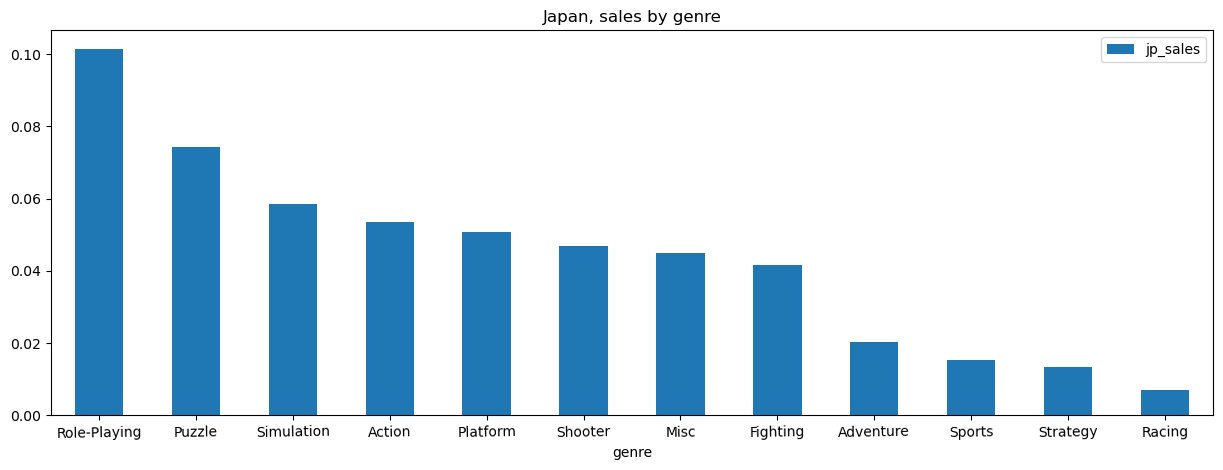

In [44]:
latest_data.pivot_table(index='genre', values='jp_sales').sort_values(by='jp_sales', ascending = False).plot(kind='bar', rot=1, title='Japan, sales by genre', figsize=(15,5))
plt.show()

And again, the difference between Europe and America is small, but Japan is a completely different market. Historically, the Japanese prefer RPGs, and [presumably there are several reasons for this](https://www.japantimes.co.jp/life/2012/05/02/digital/japans-gamers-are-starting-to-shoot-em-up/#:~:text=There%20are%20many%20reasons%20why,continue%20to%20perpetuate%20the%20cycle.):

* The rich history of domestic RPGs, on which more than one generation has grown up
* While hardware-intensive shooters were developing in the Western world, RPGs in Japan flourished on simple consoles
* With the dominance of RPGs, no one will invest money in an unpredictable new genre - people want RPGs and people will get them.

### ESRB influence

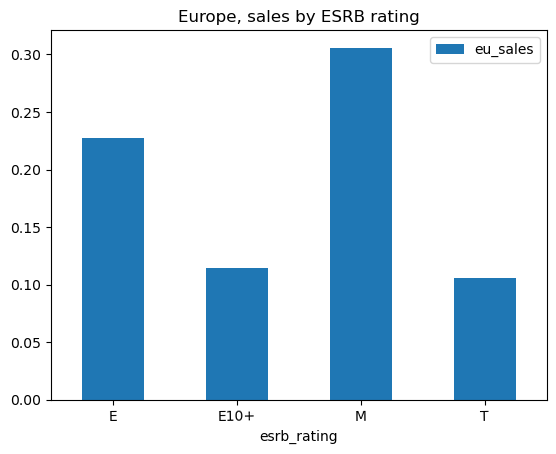

In [45]:
latest_data.pivot_table(index='esrb_rating', values='eu_sales').plot(kind='bar', rot=1, title='Europe, sales by ESRB rating')
plt.show()

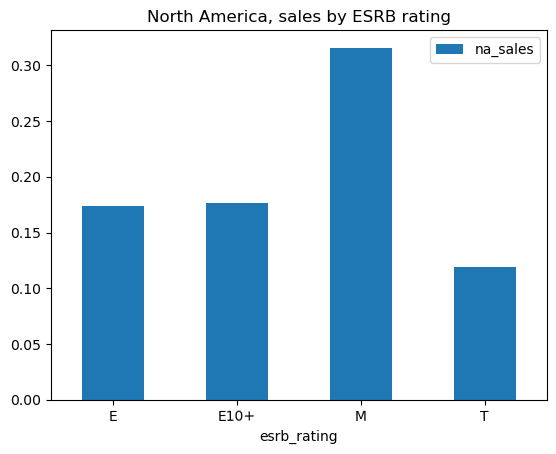

In [46]:
latest_data.pivot_table(index='esrb_rating', values='na_sales').plot(kind='bar', rot=1, title='North America, sales by ESRB rating')
plt.show()

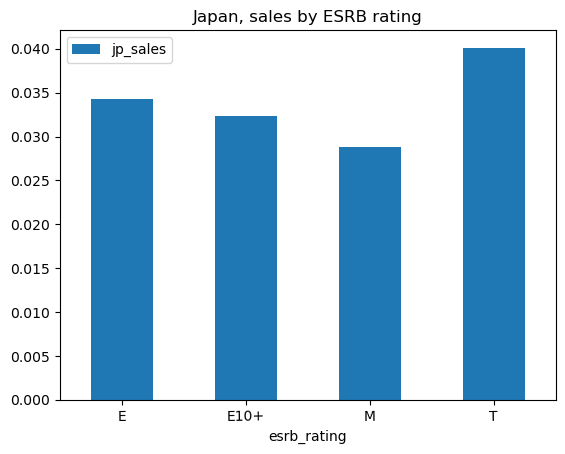

In [47]:
latest_data.pivot_table(index='esrb_rating', values='jp_sales').plot(kind='bar', rot=1, title='Japan, sales by ESRB rating')
plt.show()

And these statistics also show an interesting phenomenon for Japan. The most popular video games are rated T, "teens 13+". This is probably due to the phenomenon of Japanese censorship: due to vague and unclear legislation, authors (of any media) have to engage in careful self-censorship in order not to get punished.

## Statistical significance

### XOne and PC ratings

The null hypothesis here is there is no significant difference between XOne ratings and PC ratings.
To check this hypothesis, we are going to use scipy.stats.ttest_ind
Both arrays are large enough so that we don't have any compelling evidence that the variance will differ significantly, so there's no need to put in equal_var parametre.

In [48]:
xb_rating = latest_data[latest_data['platform'] == 'XOne']['user_score'].dropna()
pc_rating = latest_data[latest_data['platform'] == 'PC']['user_score'].dropna()
alpha = 0.05
res = st.ttest_ind(xb_rating, pc_rating)
print(res.pvalue)
if res.pvalue < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Null hypothesis cannot be rejected')

0.2778542084733835
Null hypothesis cannot be rejected


This null hypothesis stays undefeated - there's no significant difference between user scores for PC and XOne.

### Action and Sports

The null hypothesis here is there is no significant difference between Action scores and Sports scores.
To check this hypothesis, we are going to use scipy.stats.ttest_ind
Both arrays are large enough so that we don't have any compelling evidence that the variance will differ significantly, so there's no need to put in equal_var parametre.

In [56]:
action_rating = latest_data[latest_data['genre'] == 'Action']['user_score'].dropna()
sports_rating = latest_data[latest_data['genre'] == 'Sports']['user_score'].dropna()
alpha = 0.05
print('Median rating for Action:', action_rating.median())
print('Median rating for Sports', sports_rating.median())
res = st.ttest_ind(action_rating, sports_rating)
print(res.pvalue)
if res.pvalue < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Null hypothesis cannot be rejected')

Median rating for Action: 7.1
Median rating for Sports 5.55
1.0012846807938657e-13
Rejecting the null hypothesis


We can reject this null hypothesis - median ratings for Action are statistically higher than median ratings for Sports

## Results

Done:
- [x] Primary histograms were constructed to assess the data distribution
- [x] Replaced column names with snake_case
- [x] Converted release_year (to int) and user_score (to float) column data
- [x] Omissions processed, some removed, some left
- [x] Added column total_sales - the sum of sales for all regions
- [x] Reviewed data on video game releases by year
- [x] The current period for further analysis is indicated - 4 years
- [x] Changes in sales by platform were considered
- [x] A methodology was proposed and the platform life cycle was calculated
- [x] Sales leaders and outsiders in the current period were identified
- [x] Considered a box with a mustache for sales on the top 5 popular platforms in the current period
- [x] Reviewed data and identified correlation (and lack thereof) between reviews and sales for large platforms
- [x] The distribution of games by genre component is considered
- [x] The distribution by region of sales according to the popularity of gaming platforms, various genres and the influence of the ESRB rating has been studied
- [x] The hypothesis that the average user ratings for XBox One and PC are the same has been verified (and not refuted).
- [x] The hypothesis that the average user ratings for the Action and Sports genres are different has been verified (and not refuted).

The material provided is of good quality, the developers can be praised. Gaps in ratings columns are due to several factors, such as human error, lack of contemporary sampling (for instance, in 1985 there were no Internet aggregators with ratings for various video games), and the selectivity of the ESRB (some publishers, especially those who does not operate in NA, simply do not submit applications for assessment).

Conclusions from the analysis:
* Median platform life cycle - 7 years;
* The current period for analysis is 4 years;
* Top 5 platforms of all time - Playstation 2, Xbox360, Nintendo Wii, Playstation 3, Nintendo DS;
* Top 5 platforms for the current period - Playstation 4, Playstation 3, Xbox One, Nintendo 3DS, Xbox 360;
* All currently active platforms are at the stage of sales decline - it is reasonable to wait for the announcement of a new platform;
* The more active and popular the platform, the greater the variation in sales of different video games;
* The correlation between critical reviews and sales is visible, but rather weak;
* The correlation between user reviews and sales is extremely weak, even negative (sic!);
* The Action genre dominates in sales, by a huge margin (the second in sales is Shooter, which can also be classified as Action);
* The markets of Europe and North America show common trends, while the Japanese market differs greatly in the choice of consoles and genres;
* ESRB rating does not have a significant impact on sales;
* In Japan, due to legislative changes, video games without scenes of violence are more popular;
* Average user ratings for XBox One and PC are the same;
* Median user ratings for Action are statistically higher than median ratings for Sports